In [1]:
### Script for sweeping gate voltage and measuring the pinch-off curves
### Uses Dynacool PPMS at MQML and Keithley sourcementers

# Import qcodes and other necessary packages
import qcodes as qc
import numpy as np
import time
from qcodes.instrument.base import Instrument
#import plottr


# Import instrument drivers
from qcodes.instrument_drivers.tektronix.Keithley_2600_channels import Keithley_2600
from qcodes.instrument_drivers.QuantumDesign.DynaCoolPPMS       import DynaCool
from qcodes.instrument_drivers.Keysight.Keysight_34465A         import Keysight_34465A


# Import QCoDeS specific packages
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.database import initialise_database
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.data_export import flatten_1D_data_for_plot
from qcodes.dataset.experiment_container import load_experiment_by_name, new_experiment
from qcodes.instrument.base import Instrument
from qcodes.dataset.legacy_import import import_dat_file

# Import other specific packages
import matplotlib
import matplotlib.pyplot as plt
from time import sleep
from plottr.client import DataSender
from plottr.qcodes_dataset import QcodesDatasetSubscriber


In [2]:
# Create station, instantiate instruments
Instrument.close_all()
station = qc.Station()

# Connect to PPMS
ppms = DynaCool.DynaCool (name = "ppms_cryostat", address="TCPIP0::192.168.0.20::5000::SOCKET")
station.add_component(ppms)

# Connect to Keithley
keith = Keithley_2600 (name="KL", address="TCPIP0::192.168.0.51::inst0::INSTR")
station.add_component(keith)
# Set voltages to 0
keith.smua.volt(0)
keith.smub.volt(0)

# Connect to Keysight
ks  = Keysight_34465A (name = "KS", address = "TCPIP::K-34465A-06744.local::inst0::INSTR" )
station.add_component(ks)

#for inst in station.components.values():
#    inst.print_readable_snapshot()
for inst in station.components.values():
    inst.print_readable_snapshot()

Connected to:  QuantumDesign dynacool (serial:N/A, firmware:N/A) in 0.10s
Connected to: Keithley Instruments Inc. 2614B (serial:4376445, firmware:3.2.2) in 0.02s
Connected to: Keysight Technologies 34465A (serial:MY57506744, firmware:A.02.17-02.40-02.17-00.52-04-01) in 0.19s
ppms_cryostat:
	parameter           value
--------------------------------------------------------------------------------
IDN                  :	{'vendor': ' QuantumDesign', 'model': 'dynacool', 'ser...
chamber_state        :	pumping continuously 
chamber_temperature  :	300 (K)
field                :	-0.00093058 (A/m)
field_approach       :	linear 
field_rate           :	0.01 (A/m/s)
field_setpoint       :	0.01 (A/m)
magnet_state         :	holding 
temperature          :	300 (K)
temperature_rate     :	0.016667 (K/s)
temperature_setpoint :	300 (K)
temperature_settling :	no overshoot 
temperature_state    :	stable 
timeout              :	5 (s)
KL:
	parameter      value
-----------------------------------------------

Upgrading database: : 0it [00:00, ?it/s]


-4.08888e-12
0.002492646010790026
-9.728448067181455e-05


<IPython.core.display.Javascript object>


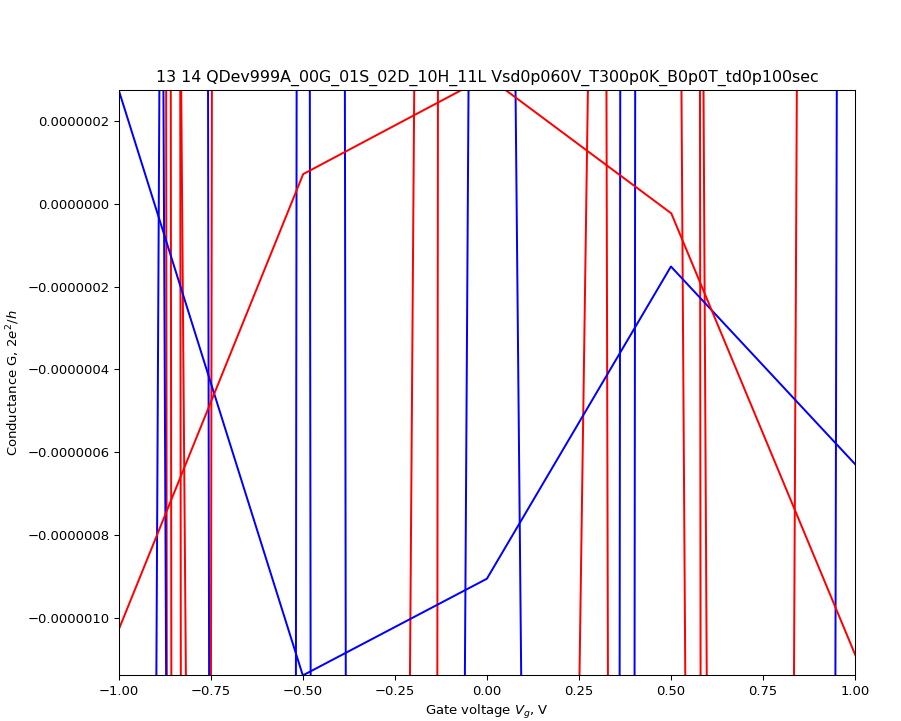

<IPython.core.display.Javascript object>


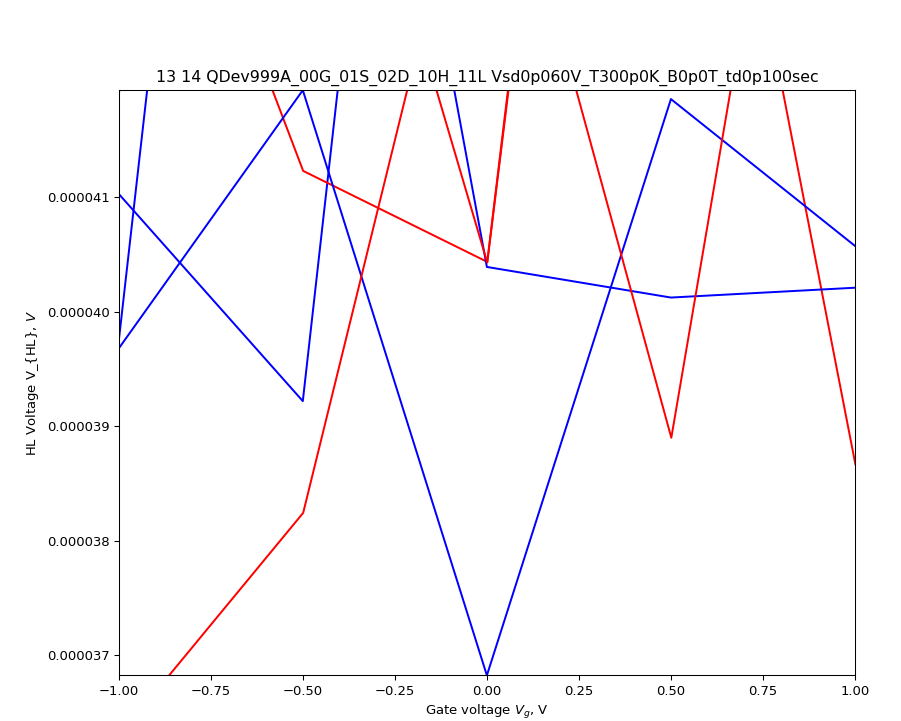

<IPython.core.display.Javascript object>


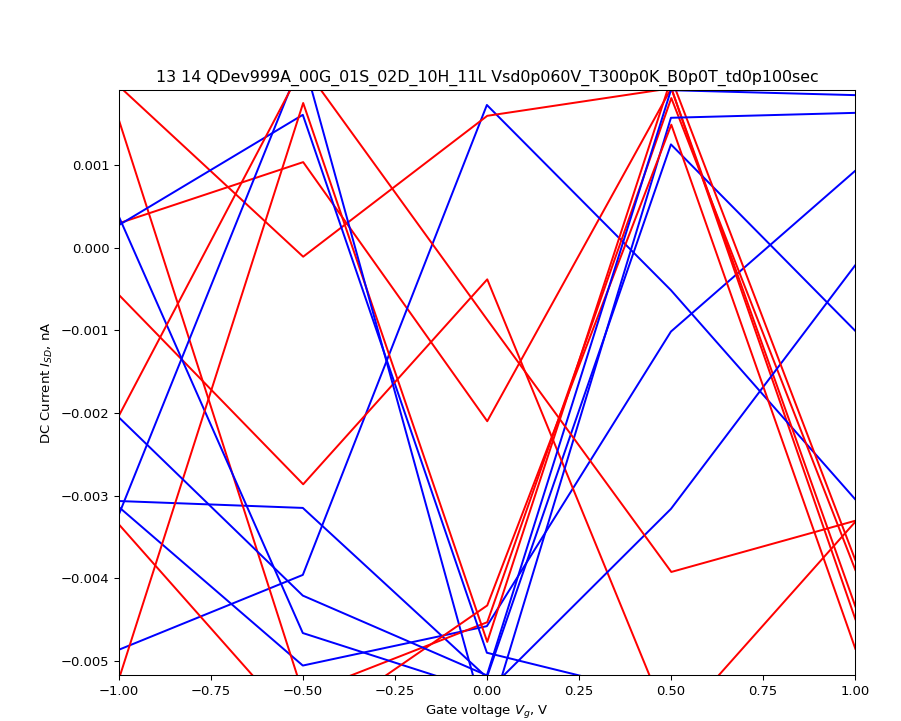

Text(0.5, 0, 'Gate voltage $V_g$, V')

In [54]:
# Initialize database, make new measurement
%matplotlib notebook

from qcodes.dataset.database import get_DB_location
from qcodes import config
import os.path
import os

# Define new names for Keithley channels
bias = keith.smua.volt
gate = keith.smub.volt

current = keith.smua.curr
leakage = keith.smub.curr

# Define new name for Keysight channel
hl_voltage = ks.volt

def esoverh():
     DCV=bias() 
     DCcurrent=keith.smua.curr()
     cond=(DCcurrent/DCV)/7.7480917e-05 
     return cond
create = True
try:
    keith.smua.add_parameter("quantcond", label="G", unit="2e^2/h",
                               get_cmd=esoverh)
except KeyError:
    print("parameter already exists. Deleting. Try again")
    create = False
    del keith.smua.parameters['quantcond']


#__________________ARGUEMENT TO AVOID CREATING EXPERIMENTS WHEN STH FAILS_____
if create == True:
    # Load the file and create a new experiment
    config.current_config.core.db_location = 'C:/Users/quantum_ppms/Desktop/Results/MQML_PPMS_results.db'

    
    """## FIRST OPTION
    # Create a new experiment (when you start measuring a new device) 
    new_experiment(name='TEST', sample_name = 'DUMMY') # Use something general for name and sample_name;
                                                       # you will re-define it in the next cell  
    meas = Measurement()"""

    ## SECOND OPTION
    # Load an older experiment
    figpath = 'C:/Users/quantum_ppms/Desktop/Results/'
    experiment = Experiment(path_to_db = config.current_config.core.db_location, exp_id = 4) #remember to complete the exp_id
    meas = Measurement(exp = experiment)


print(current())
print(keith.smua.quantcond())
print(esoverh())
quant_cond = keith.smua.quantcond

#__________________FUNCTIONS FOR MEASURING_____________________________________
def wait_for_field():
    time.sleep(3)
    Magnet_state = ppms.magnet_state()
    while Magnet_state is not 'holding':
        time.sleep(1)
        Magnet_state = ppms.magnet_state()
    print ("Field is Ready")
    return
def wait_for_field_ramp():
    Magnet_state = ppms.magnet_state()
    while Magnet_state is not 'ramping':
        time.sleep(0.1)
        Magnet_state = ppms.magnet_state()
    return
def field_ready():
    return ppms.magnet_state() == 'holding'
def wait_for_temp():
    Temp_state = ppms.temperature_state()
    while not (Temp_state is 'near' or  Temp_state is 'stable'):
        time.sleep(1)
        Temp_state = ppms.temperature_state()
        print("Waiting for temperature")
    return


#__________________FIGURES INITIALIZATION______________________________________

fig1, ax1 = plt.subplots(1,figsize=(10, 8))
ax1.set_ylabel(r'Conductance G, $2e^2/h$')
ax1.set_xlabel(r'Gate voltage $V_g$, V')
fig2, ax2 = plt.subplots(1,figsize=(10, 8))
ax2.set_ylabel(r'HL Voltage V_{HL}, $V$')
ax2.set_xlabel(r'Gate voltage $V_g$, V')
fig3, ax3 = plt.subplots(1,figsize=(10, 8))
ax3.set_ylabel(r'DC Current $I_{SD}$, nA')
ax3.set_xlabel(r'Gate voltage $V_g$, V')

# Sweeping Gate Voltage with Bias Voltage steps

In [61]:
#__________________IMPORT ALL THE NECESSARY PARAMETERS_________________________

Lo = 500 # Channel lenght in nm
W  = 100 # Channel width  in nm
D  = -1+1+0 # Wire direction (need to add signs; is zero add +)
growth_column = 2
growth_line = 11

temperature = 300 #K
magnetic_field = 0. * 1e-3 #mT
timedelay = 0.1 #s

# SD Bias Sweep multiple runs
# Create bias values as steps
initial = 1e-3 #mV
final   = 10e-3 #mV
step    = 2e-3 #mV
#param_range = np.arange(initial, final, step)
# Alternativelly, create a list with arbitary values
param_range = [0.2e-3, 6e-2]

# Gate setpoint 
gate_min = -1
gate_max = +1
Npoints  = 5


#__________________OUTER LOOP FOR BIAS STEPS___________________________________
for var_param in param_range:
    bias_setpoint = var_param
    
    #__________________NAME OF THE MEASUREMENT_____________________________________
    Experiment_name = "Vsd" + "{:.3f}".format(bias_setpoint ) + "V_" +\
                      "T"   + "{:.1f}".format(temperature   ) + "K_" +\
                      "B"   + "{:.1f}".format(magnetic_field) + "T_" +\
                      "td"  + "{:.3f}".format(timedelay     ) + "sec"
    list_name = list(Experiment_name)
    for i in range(len(Experiment_name)):
        if list_name[i] == ".":
            list_name[i] = "p"
    Experiment_name = ''.join(list_name)    
    
    # Connections
    G = '00'
    S = '01'
    D = '02'
    H = '10' # if there is two probe measurement just add '00'
    L = '11' # if there is two probe measurement just add '00'
    
    Sample_name = "QDev999A_{0}G_{1}S_{2}D_{3}H_{4}L".format(G,S,D,H,L)
    
    
    #__________________BEGINNING OF THE MEASUREMENT________________________________
    meas.register_parameter(gate)  # register the independent parameter

    meas.register_parameter(current, setpoints=(gate,))     # register the dependent one
    meas.register_parameter(hl_voltage, setpoints=(gate,))  # register the dependent one
    meas.register_parameter(quant_cond, setpoints=(gate,))  # register the dependent one
    meas.register_parameter(leakage, setpoints=(gate,))     # register the dependent one
    
    
    meas.add_before_run(lambda: ppms.field_setpoint(magnetic_field), ())     # set magnetic field
    meas.add_before_run(lambda: ppms.temperature_setpoint(temperature), ())  # set temperature
    
    #meas.add_before_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize
    #meas.add_before_run(lambda: wait_for_temp() , ())  # wait for  temperature   to stabilize
    
    meas.add_before_run(lambda: keith.smua.output('on'), ())  # Turn Keithley output A on
    meas.add_before_run(lambda: keith.smub.output('on'), ())  # Turn Keithley output B on
    ks.display_text('Sweeping Voltage') # Make Keysight faster
    
    meas.add_before_run(lambda: bias(bias_setpoint), ())  # set bias to defined value
    meas.add_before_run(lambda: time.sleep(1), ())        # delay 1s

    
    meas.add_after_run(lambda: bias(0), ())  # Set bias to 0
    meas.add_after_run(lambda: keith.smua.output('off'), ())  # Turn Keithley output A off
    meas.add_after_run(lambda: keith.smub.output('off'), ())  # Turn Keithley output B off

    meas.write_period = 0.12

    with meas.run() as datasaver:
        datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                    min_wait=0, min_count=1)
        
        dataid_up = datasaver.run_id  # convenient to have for plotting 
        dataset = qc.load_by_id(dataid_up)

        plt.figure(fig1.number)
        pt11, = ax1.plot(0,0,'b-',label='up')
        pt12, = ax1.plot(0,0,'r-',label='down')
        plt.grid()
        
        plt.figure(fig2.number)
        pt21, = ax2.plot(0,0,'b-',label='up')
        pt22, = ax2.plot(0,0,'r-',label='down')
        plt.grid()

        plt.figure(fig3.number)
        pt31, = ax3.plot(0,0,'b-',label='up')
        pt32, = ax3.plot(0,0,'r-',label='down')
        plt.grid()

        plt.title(str(dataid_up) + Experiment_name + Sample_name)

        
        #__________________TRACE GATE__________________________________________________
        for gate_setpoint in np.linspace(gate_max, gate_min, Npoints):
            
            time.sleep(timedelay)
            gate(gate_setpoint)
            V_g  = gate()
            I_sd = current()
            V_HL = hl_voltage()
            I_q  = quant_cond()
            I_g  = leakage()
            datasaver.add_result((gate,       V_g ),
                                 (current,    I_sd),
                                 (hl_voltage, V_HL),
                                 (quant_cond, I_q ),
                                 (leakage,    I_g ))

            dataset = qc.load_by_id(dataid_up)

            
            
            dataid_up = datasaver.run_id  # convenient to have for plotting 

            labels = dataset.parameters.split(",")       
            v_name  = labels[0]
            c_name  = labels[3]
            hl_name = labels[2]
            i_name  = labels[1]
            l_name  = labels[4]
            
            v  = flatten_1D_data_for_plot(dataset.get_data(v_name)) 
            c  = flatten_1D_data_for_plot(dataset.get_data(c_name)) 
            hl = flatten_1D_data_for_plot(dataset.get_data(hl_name))
            i  = flatten_1D_data_for_plot(dataset.get_data(i_name))*1e9 # nA

            plt.figure(fig1.number)   
            if len(v)>1:
                pt11.set_ydata(c)
                pt11.set_xdata(v)
                ax1.set_ylim([np.nanmin(c),np.nanmax(c)])
                ax1.set_xlim([np.nanmin(v),np.nanmax(v)])
            fig1.canvas.draw()

            plt.figure(fig2.number)   
            if len(v)>1:
                pt21.set_ydata(hl)
                pt21.set_xdata(v)
                ax2.set_ylim([np.nanmin(hl),np.nanmax(hl)])
                ax2.set_xlim([np.nanmin(v),np.nanmax(v)])
            fig2.canvas.draw()

            plt.figure(fig3.number)   
            if len(v)>1:
                pt31.set_ydata(i)
                pt31.set_xdata(v)
                ax3.set_ylim([np.nanmin(i),np.nanmax(i)])
                ax3.set_xlim([np.nanmin(v),np.nanmax(v)])
            fig3.canvas.draw()

    with meas.run() as datasaver:
        datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                    min_wait=0, min_count=1)
        dataid_down = datasaver.run_id  # convenient to have for plotting 

        #__________________RETRACE GATE________________________________________________
        for gate_setpoint in np.linspace(gate_min, gate_max, Npoints):
            
            time.sleep(timedelay)
            gate(gate_setpoint+0.001)
            V_g  = gate()
            I_sd = current()
            V_HL = hl_voltage()
            I_q  = quant_cond()
            I_g  = leakage()
            datasaver.add_result((gate,       V_g ),
                                 (current,    I_sd),
                                 (hl_voltage, V_HL),
                                 (quant_cond, I_q ),
                                 (leakage,    I_g ))
            dataset = qc.load_by_id(dataid_down)

            v  = flatten_1D_data_for_plot(dataset.get_data(v_name)) 
            c  = flatten_1D_data_for_plot(dataset.get_data(c_name)) 
            hl = flatten_1D_data_for_plot(dataset.get_data(hl_name))
            i  = flatten_1D_data_for_plot(dataset.get_data(i_name))*1e9 # nA


            plt.figure(fig1.number) 
            pt12.set_ydata(c)
            pt12.set_xdata(v)
            fig1.canvas.draw()

            plt.figure(fig2.number) 
            pt22.set_ydata(hl)
            pt22.set_xdata(v)
            fig2.canvas.draw()

            plt.figure(fig3.number)   
            pt32.set_ydata(i)
            pt32.set_xdata(v)
            fig3.canvas.draw()
    
    #__________________SAVE FIGURES_______________________________________________
    plt.figure(fig1.number)  
    plt.title(str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name)
    plt.grid()
    fig1.canvas.draw()
    #plt.savefig(figpath + str(dataid_up) + '_' + str(dataid_down) + Sample_name + Experiment_name + '_c_.svg')
    
    plt.figure(fig2.number)  
    plt.title(str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name)
    plt.grid()
    fig2.canvas.draw()
    #plt.savefig(figpath + str(dataid_up) + '_' + str(dataid_down) + Sample_name + Experiment_name + '_hl_.svg')

    plt.figure(fig3.number)  
    plt.title(str(dataid_up) + ' ' + str(dataid_down) + ' ' + Sample_name + ' ' + Experiment_name)
    plt.grid()
    fig3.canvas.draw()
    #plt.savefig(figpath + str(dataid_up) + '_' + str(dataid_down) + Sample_name + Experiment_name + '_i_.svg')
    
    #__________________LOG PARAMETERS IN A DICTIONARY_____________________________
    # Create the dictionary
    log = {}

    log['temperature'] = temperature
    log['magnetic_field'] = magnetic_field
    log['timedelay'] = timedelay
    log['bias_setpoint'] = bias_setpoint
    log['gate_min'] = gate_min
    log['gate_max'] = gate_max
    log['Npoints'] = Npoints
    log['ConG'] = G
    log['ConS'] = S
    log['ConD'] = D
    log['ConH'] = H
    log['ConL'] = L 
    log['Ch. lenght'] = Lo
    log['Ch. width'] = W
    log['Diretion'] = D
    log['growth_column'] = growth_column
    log['growth_line'] = growth_line
    print(log)
    
    #__________________SAVE THE LOG DICTIONARY AS TXT_____________________________
    #save.txt

    
#__________________THINGS NEEDED TO DO AFTER MEASURING________________________
# Set magnetic field to zero 
ppms.field_setpoint(0)
wait_for_field()
print(ppms.field_setpoint())
# Reset Keysight to display mode
ks.display_text('')




Starting experimental run with id: 11
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Starting experimental run with id: 12
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
{'temperature': 300, 'magnetic_field': 0.0, 'timedelay': 0.1, 'bias_setpoint': 0.0002, 'gate_min': -1, 'gate_max': 1, 'Npoints': 5, 'ConG': '00', 'ConS': '01', 'ConD': '02', 'ConH': '10', 'ConL': '11', 'Ch. lenght': 500, 'Ch. width': 100, 'Diretion': '02', 'growth_column': 2, 'growth_line': 11}
Starting experimental run with id: 13
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Starting experimental run with id: 14
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
{'temperature': 300, 'magnetic_field': 0.0, 'timedelay': 0.1, 'bias_setp

# Characterization / Machine Learning Cell (in progress)

### Fisrt part: Calculations

In [ ]:
# Load data by id run (load both sweep up and down of a measurement)
    # Loaded
# sort data

# Calculate:
# Minimum indticated voltage: Zero values till a datapoint that has orders of magnitude difference
    # Search for it
# Log it
log['SU_VminI'] = SU_VminI
log['SD_VminI'] = SD_VminI

# Saturation current: start from max I values and keep set a range that after that currentis not saturated
    # Search for it
# Log it as well as the Voltage Values
log['SU_Is'] = SU_Is
log['SD_Is'] = SD_Is
log['SU_Vs'] = SU_Vs
log['SD_Vs'] = SD_Vs

# Hysteresis
    # Calculate sweep up and down integrals
# Log them
log['SU_Int'] = SU_Int
log['SD_Int'] = SD_Int
# Log Hysteresis
log['Hysteresis'] = SU_Int - SD_Int


# Append data to the txt log file

### Second part: Pick data from plot

In [ ]:
#create interactive plot that can pick points to add the beginning of the tail (fitting minimum)
log['SU_Vtail'] = Vtail
log['SU_Gtail'] = Gtail
log['SD_Vtail'] = Vtail
log['SD_Gtail'] = Gtail


# If you are satisfied with your picks, append data to the txt file
# Otherwise re-excecute this cell
# After some tries that you are confident the results look good append data to the txt log file

### Third part: Gul fit

In [ ]:
#set the range for the fitting 
#fit
#obtain the results
# Log the results
log['SU_Vth'] = SU_Vth
log['SU_DV'] = SU_Vth-SU_VminI
log['SU_muC'] = Lo**2/SU_LLmuC
log['SU_Rs'] = SU_Rs

log['SD_Vth'] = SD_Vth
log['SD_DV'] = SD_Vth - SD_VminI
log['SD_muC'] = Lo**2/SD_LLmuC
log['SD_Rs'] = SD_Rs

# If you are satisfied with your fit results, append data to the txt file
# Otherwise re-excecute this cell
# After some tries that you are confident the results look good append data to the txt log file